In [117]:
import autograd.numpy as np
import scipy as sp
from scipy.optimize import root
import matplotlib.pyplot as plt
import scipy.optimize as opt
import mpmath as mpm

In [118]:
%matplotlib notebook

# Bridgeman Mixing Rule

For mixing N species (according to wikipedia) the opacity of a spherical scatterer made up of n species of homogeniously mixed scatterers obbeys:
\begin{equation}
\sum_i\,\delta_i\,\frac{\sigma_i - \sigma_e}{\sigma_i + (n-1) \sigma_e}=0,
\end{equation}
where $\delta _{i}$ and $\sigma _{i}$ are respectively the fraction and the conductivity of each component, and 
$\sigma _{e}$ is the effective conductivity of the medium.


## Solving the equation

The problem is therefore is an optimisation problem, as all values but $\sigma _{e}$ are known. It should therefore be possible to find the root of the problem using N-R or a Metropolis algo MC-MC method (which may work better if the solution manifold has many local minima in $\mathbb{C}$ space).


#### Building the optimisation problem
All operations are done using numpy array broadcasts in hope that it will speed up the operation (see [numpy documentation](https://numpy.org/devdocs/user/basics.broadcasting.html) for reference). ```sigma``` is the conductivity array, ```delta``` is the mass fraction array,  and ```sigma_eff``` is the unknown, the effective conductivity.

In [119]:
def SumFunc_Generic(delta,sigma,sigma_eff):
    n=len(delta)
    return np.sum(delta*(sigma-sigma_eff)/(sigma+((n-1)*sigma_eff)))

In [120]:
def makeProblem(delta_array,sigma_array):
    f=lambda sigma_e : SumFunc_Generic(delta_array,sigma_array,sigma_e)
    return f

The function ```makeProblem(delta_array,sigma_array)``` takes ```delta``` and  ```sigma``` and returns a lambda function ``` f(sigma_e)=SumFunc_Generic(delta=delta_array,sigma=sigma_array,sigma_e)```. This will make setting up the optimisation problem easier.

#### Reading in the opacity tables
Opacity values are read into complex arrays

In [121]:
data=np.loadtxt("new_cons/Normal_silicates/n_olivine.dat")
n_olivine=data[:,1]+1j*data[:,2]
data=np.loadtxt("new_cons/Normal_silicates/n_orthopyroxene.dat")
n_pyroxene=data[:,1]+1j*data[:,2]
data =np.loadtxt("new_cons/Normal_silicates/n_iron.dat")
n_iron =data[:,1]+1j*data[:,2]
data =np.loadtxt("new_cons/Normal_silicates/n_troilite.dat")
n_troilite =data[:,1]+1j*data[:,2]
data =np.loadtxt("new_cons/Normal_silicates/n_volatile_organics.dat")
n_organics =data[:,1]+1j*data[:,2]
data =np.loadtxt("new_cons/Normal_silicates/n_water_ice.dat")
n_Water_ice=data[:,1]+1j*data[:,2]
lambda_k= data[:,0]*1e-4
nu=(sp.constants.speed_of_light*1e2)/lambda_k

In [122]:
data= np.loadtxt("semenov.dat",dtype = np.float128)
nusem= data[:,0]
Kappasem= data[:,1]

#### Reading in the abundancy values

In [123]:
import functions_op as fop

In [124]:
dict_nrm=fop.dic_comp('NRM')

In [125]:
frac_olivine=dict_nrm["frac_olivine"]
frac_iron=dict_nrm["frac_iron"]
frac_pyroxene=dict_nrm["frac_pyroxene"]
frac_organics=dict_nrm["frac_organics"]
frac_Troilite=dict_nrm["frac_Troilite"]
frac_Water_ice=dict_nrm["frac_Water_ice"]

rho_olivine=dict_nrm["dens_olivine"]
rho_iron=dict_nrm["dens_iron"]
rho_pyroxene=dict_nrm["dens_pyroxene"]
rho_organics=dict_nrm["dens_organics"]
rho_Troilite=dict_nrm["dens_Troilite"]
rho_Water_ice=dict_nrm["dens_Water_ice"]

#### Making the arrays be of the correct shape

In [177]:
Frac_array= np.asarray([frac_olivine,frac_iron,frac_pyroxene,frac_organics,frac_Troilite,frac_Water_ice])
dens_array= np.asarray([rho_olivine,rho_iron,rho_pyroxene,rho_organics,rho_Troilite,rho_Water_ice])
sigma_array=np.asarray([n_olivine,n_iron,n_pyroxene,n_organics,n_troilite,n_Water_ice])

In [178]:
sigma_array[:,0]

array([1.6512+0.011699j , 1.4453+0.89017j  , 1.5921+0.0040824j,
       1.3014+0.86125j  , 4.2529+0.75934j  , 1.2576+0.078691j ])

#### Solver
Complex roots are found using [Muller's](https://en.wikipedia.org/wiki/Muller's_method) method packaged in [MPM](https://mpmath.org/doc/current/calculus/optimization.html)

In [195]:
for i in range(len(n_mixture)):
    f=makeProblem(Frac_array,sigma_array[:,i])
    mixture=mpm.findroot(f,x0=1.0+1.0j,solver="muller",df=f_prime)
    n_mixture[i]=mixture

#### Generating opacity curve of a dust distribution
The dialectrics calculated earlier are then used to calculate the opacity of MRN size distributed dust grains

In [192]:
def sizes_distr(smin,smax,ndust):
    sdust = np.zeros(ndust)
    sdb=np.logspace(np.log10(smin),np.log10(smax),ndust+1)
    for i in range(0,ndust):
        sdust[i]=np.sqrt(sdb[i]*sdb[i+1])
    return [sdust,sdb]

def Kappa_dust(epsilon_dust,n_mix,grain_sizes):
    ee1 = fop.e1(np.real(n_mix),np.imag(n_mix))
    ee2 = fop.e2(np.real(n_mix),np.imag(n_mix))
    x_dust = [fop.xj(lambda_k,size,size) for size in grain_sizes]
    H_dust=  [fop.Hj(x_d,ee1,ee2) for x_d in x_dust]
    grain_dens=np.sum(Frac_array*dens_array)/len(dens_array)
    Kappa_i=lambda epsilon_i,H_dust_i: fop.Kappaj(epsilon_i,grain_dens,H_dust_i,sigma,sigma,sigma)
    return np.sum([Kappa_i(epsi,hdi) for epsi,hdi in zip(H_dust,epsilon_dust)],axis=0)

In [193]:
ndust=500 #number of dust species
smin =2.5e-7 # Min grain size
smax=5e-4 # Max grain size

epsilon_0=0.013986 #Dust-to-gas ratio from Semenov
sdust,sdb=sizes_distr(smin,smax,ndust) 

rho_n=np.zeros(ndust)  
for j in range(0,ndust):
    rho_n[j]=fop.mrn_pollack(sdust[j]) #Calculates number density per species using the same distribution as in Semenov, it's not exactly an MRN
    
rho_n=rho_n/(sdust**3.) #Mass distribution
epsilon_dust=epsilon_0*rho_n/np.sum(rho_n)

k_dust=Kappa_dust(epsilon_dust,n_mixture,sdust)

<IPython.core.display.Javascript object>


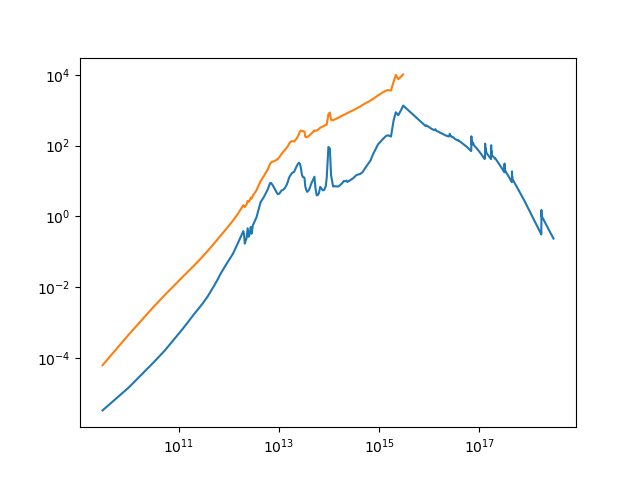

In [194]:
plt.figure()
plt.loglog(nusem,Kappasem)
plt.loglog(nu,k_dust)